In [1]:
# Load packages
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model

In [2]:
# Set the style of display
plt.style.use("ggplot")
%matplotlib inline

In [63]:
# Load the star data
data = pd.read_csv('./data/image_database.txt')

In [67]:
# Select for stars taken from a certain camera
camera = "mx"
image_num = "2"
im_label = camera + image_num
idx_err_r_mx = data.filter(regex=("err_r_" + im_label)).notnull().any(axis=1)
df_err_r_mx = data.filter(regex=("err_r_" + im_label)).loc[idx_err_r_mx]

idx_err_ang_mx = data.filter(regex=("err_ang_" + im_label)).notnull().any(axis=1)
df_err_ang_mx = data.filter(regex=("err_ang_" + im_label)).loc[idx_err_ang_mx]

idx_err_mag_mx = data.filter(regex=("err_mag_" + im_label)).notnull().any(axis=1)
df_err_mag_mx = data.filter(regex=("err_mag_" + im_label)).loc[idx_err_mag_mx]

# Join the above dataframes and remove NaN rows
df = df_err_r_mx.join(df_err_mag_mx)
df = df.join(df_err_ang_mx)
df = df[['err_mag_' + im_label, 'err_r_' + im_label, 'err_ang_' + im_label]].dropna()

In [68]:
df.head()

,err_mag_mx2,err_r_mx2,err_ang_mx2
35,2.827684,770.984141,93.682335
36,2.350709,460.124584,128.987928
43,2.269882,697.969711,114.014828
49,2.341144,640.854338,119.470011
52,2.445179,664.875172,116.502640


In [69]:
df.describe()

,err_mag_mx2,err_r_mx2,err_ang_mx2
count,42.000000,42.000000,42.000000
mean,2.081457,516.026965,112.564229
std,0.567165,261.100464,28.041184
min,1.091238,40.450732,15.155884
25%,1.610127,269.642318,112.699100
50%,1.975092,611.997707,115.951747
75%,2.517162,730.613785,122.605594
max,3.126335,944.161383,170.359913


## Build a Regression Model


In [70]:
y_train = np.reshape(df.err_mag_mx2.as_matrix(), (df.shape[0], 1))
x_train = np.reshape(df.err_r_mx2.as_matrix(), (df.shape[0], 1))

# Create polynomial features
x_train_poly = np.hstack((x_train, np.power(x_train,2), np.power(x_train,3)))
#poly = preprocessing.PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
#x_train_poly=poly.fit_transform(x_train)

# Fit a linear regression model
LR = linear_model.LinearRegression(normalize=True)
LR.fit(x_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

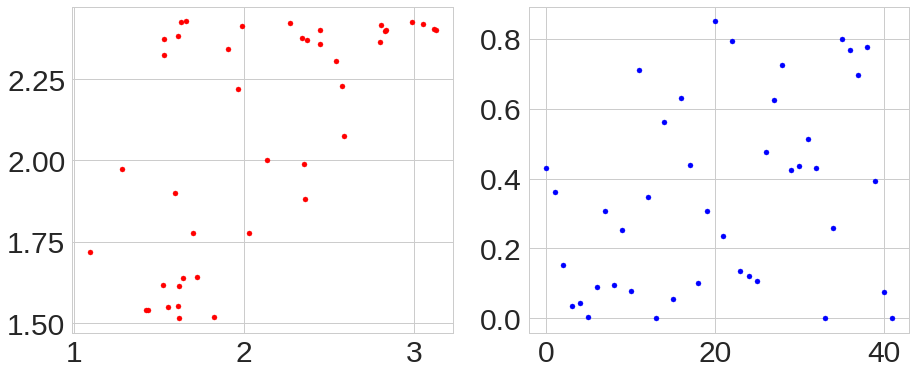

In [84]:
# Plot the predicted error magnitude vs "true" error magnitude
fig, axes = plt.subplots(1,2, figsize=(15,6))
y_pred = LR.predict(x_train_poly)
axes[0].plot(y_train, y_pred, '.r')

# Plot the absolute error
abs_err = np.abs(y_train - y_pred) 
axes[1].plot(abs_err, '.b')

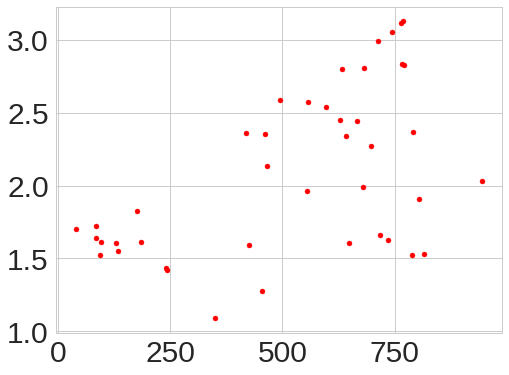

In [72]:
# Plot error vector's distance-to-center-pixel vs "true " error magnitude 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_train,y_train, '.r')

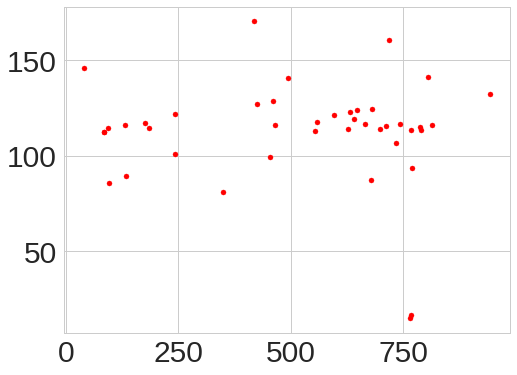

In [73]:
# Plot error vector's distance-to-center-pixel vs error velctor angle
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_train, df.err_ang_mx2.as_matrix(), '.r')

In [74]:
df.head()

,err_mag_mx2,err_r_mx2,err_ang_mx2
35,2.827684,770.984141,93.682335
36,2.350709,460.124584,128.987928
43,2.269882,697.969711,114.014828
49,2.341144,640.854338,119.470011
52,2.445179,664.875172,116.502640


In [75]:
LR.coef_

array([[ -5.07630313e-03,   1.69064560e-05,  -1.24235263e-08]])

In [76]:
LR.intercept_

array([ 1.95492623])

## Model Evaluation